# wps-pipeline-notebook

This is jupyter notebook for the example use of the wps services that are provided by the GFZ in the RIESGOS project.


In [2]:
%load_ext autoreload
%autoreload 2
import owslib.wps as wps
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import numpy as np
import lxml.etree as le
#from mpl_toolkits.basemap import Basemap
import gfzwpsformatconversions
#
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/lib/python3/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
WPS_URL = 'http://rz-vm140.gfz-potsdam.de/wps/WebProcessingService'

In [4]:
server = wps.WebProcessingService(WPS_URL)

So lets see what processes are supported:

In [5]:
server.processes

[<owslib.wps.Process org.n52.wps.server.algorithm.r.AnnotationValidation>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapTransformationProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.XMLCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeMLTransformationProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeMLCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedAssetmasterProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedModelpropProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.JSONCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedShakygroundProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algori

Some of them are test processes, some others are included by default.
We will focus on the following:

| Process | Use case |
|---------|----------|
| Assetmaster | Extraction of the exposure model for a given location |
| Modelprop | Extraction of the vulnerability model with the fragility functions |
| Quakeledger | Earth quake catalog that we use to search for specific events |
| Shakyground | Computation of the pga for a given event |
| Deus | Update of the exposure model with damage states after using the intensities of a given event |

The processes are following a pipeline.

1. Assetmaster
2. Modelprop
3. Quakeledger
4. Shakyground
5. Deus

The order for assetmaster, modelprop and quakeledger can change is not strongly needed. They can be used in any order. However we need to use quakeledger before shakyground and we have to use all other processes before deus (as it needs the exposure model, the fragility functions and the intenstities computed in shakyground).

## Assetmaster
We will start working with the assetmaster dataset.

In [6]:
ID_ASSETMASTER = 'org.n52.gfz.riesgos.algorithm.impl.AssetmasterProcess'

In [7]:
execution_assetmaster = server.execute(
    identifier=ID_ASSETMASTER, 
    inputs=[
        ('lonmin', '-71.8'),
        ('lonmax', '-71.4'),
        ('latmin', '-33.2'),
        ('latmax', '-33.0'),
        ('schema', 'SARA_v1.0'),
        ('assettype', 'res'),
        ('querymode', 'intersects')
    ],
    output=[('selectedRowsGeoJson', True)]
)

wps.monitorExecution(execution_assetmaster)
print('Successful: {}'.format(execution_assetmaster.isSucceded()))

Successful: True


In [8]:
assetmaster_output_reference = execution_assetmaster.processOutputs[0].reference
assetmaster_output_pure = requests.get(assetmaster_output_reference).text
assetmaster_output = gpd.read_file(assetmaster_output_reference)

In [9]:
assetmaster_output.head()

gid          name                                               expo  \
0     0 1  VINA DEL MAR  {'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...   
1    0 10  VINA DEL MAR  {'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...   
2  0 1005  VINA DEL MAR  {'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...   
3  0 1008  VINA DEL MAR  {'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...   
4   0 101  VINA DEL MAR  {'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...   

                                            geometry  
0  POLYGON ((-71.4765109995829 -33.01033200032151...  
1  POLYGON ((-71.48944699987908 -32.9985789997210...  
2  POLYGON ((-71.55798300021524 -33.0261810000530...  
3  POLYGON ((-71.55057300024373 -33.0167959998354...  
4  POLYGON ((-71.53613700002251 -33.0540340002688...

In [10]:
pd.DataFrame(assetmaster_output.iloc[0].expo)

Taxonomy  Buildings          name        Region  Population  \
11       MUR-ADO-H1-2          0  VINA DEL MAR  VINA DEL MAR          15   
12           MUR-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
13     MUR-STDRE-H1-2          0  VINA DEL MAR  VINA DEL MAR          15   
14                UNK          0  VINA DEL MAR  VINA DEL MAR          15   
15         W-WLI-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
16          W-WS-H1-2          0  VINA DEL MAR  VINA DEL MAR          15   
0    CR-LWAL-DNO-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
1    CR-LWAL-DNO-H4-7          0  VINA DEL MAR  VINA DEL MAR          15   
2    CR-LWAL-DUC-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
3    CR-LWAL-DUC-H4-7          0  VINA DEL MAR  VINA DEL MAR          15   
4   CR-LWAL-DUC-H8-19          0  VINA DEL MAR  VINA DEL MAR          15   
5     CR-PC-LWAL-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
6         ER-ETR-H1-2          0  VINA DEL MAR  VINA DEL MAR          15   
7        MCF-DNO-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
8        MCF-DUC-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
9         MR-DNO-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   
10        MR-DUC-H1-3          0  VINA DEL MAR  VINA DEL MAR          15   

    Repl-cost-USD-bdg          id Damage  Dwellings  
11                  0  AREA # 0 1     D0          0  
12                  0  AREA # 0 1     D0          0  
13                  0  AREA # 0 1     D0          0  
14                  0  AREA # 0 1     D0          0  
15                  0  AREA # 0 1     D0          0  
16                  0  AREA # 0 1     D0          0  
0                   0  AREA # 0 1     D0          0  
1                   0  AREA # 0 1     D0          0  
2                   0  AREA # 0 1     D0          0  
3                   0  AREA # 0 1     D0          0  
4                   0  AREA # 0 1     D0          0  
5                   0  AREA # 0 1     D0          0  
6                   0  AREA # 0 1     D0          0  
7                   0  AREA # 0 1     D0          0  
8                   0  AREA # 0 1     D0          0  
9                   0  AREA # 0 1     D0          0  
10                  0  AREA # 0 1     D0          0

### TODO
Add a basemap for the cells.

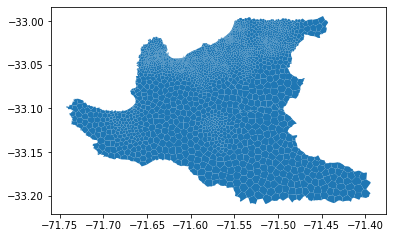

In [11]:
assetmaster_output.plot()

## Modelprop
Next is the modelprop process.

In [12]:
ID_MODELPROP = 'org.n52.gfz.riesgos.algorithm.impl.ModelpropProcess'

In [13]:
execution_modelprop = server.execute(
    identifier=ID_MODELPROP, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('assetcategory', 'buildings'),
        ('losscategory', 'structural'),
        ('taxonomies', ''),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_modelprop)
print('Successful: {}'.format(execution_modelprop.isSucceded()))

Successful: True


In [14]:
modelprop_output_reference = execution_modelprop.processOutputs[0].reference
modelprop_output_pure = requests.get(modelprop_output_reference).text
modelprop_output = requests.get(modelprop_output_reference).json()

In [15]:
modelprop_output

{'data': [{'D1_2_mean': -1.1344,
   'D1_2_stddev': 0.328,
   'D1_3_mean': -0.6696,
   'D1_3_stddev': 0.322,
   'D1_4_mean': -0.33033,
   'D1_4_stddev': 0.317,
   'D1_mean': -1.418,
   'D1_stddev': 0.31,
   'D2_3_mean': -0.6696,
   'D2_3_stddev': 0.322,
   'D2_4_mean': -0.33033,
   'D2_4_stddev': 0.317,
   'D2_mean': -0.709,
   'D2_stddev': 0.328,
   'D3_4_mean': -0.33033,
   'D3_4_stddev': 0.317,
   'D3_mean': -0.496,
   'D3_stddev': 0.322,
   'D4_mean': -0.231,
   'D4_stddev': 0.317,
   'id': 'unique_id',
   'im_max': 1.0,
   'im_min': 0.0,
   'imt': 'PGA',
   'imu': 'g',
   'taxonomy': 'MUR-H1'},
  {'D1_2_mean': -1.1344,
   'D1_2_stddev': 0.328,
   'D1_3_mean': -0.6696,
   'D1_3_stddev': 0.322,
   'D1_4_mean': -0.33033,
   'D1_4_stddev': 0.317,
   'D1_mean': -1.418,
   'D1_stddev': 0.31,
   'D2_3_mean': -0.6696,
   'D2_3_stddev': 0.322,
   'D2_4_mean': -0.33033,
   'D2_4_stddev': 0.317,
   'D2_mean': -0.709,
   'D2_stddev': 0.328,
   'D3_4_mean': -0.33033,
   'D3_4_stddev': 0.317,
  

In [16]:
urm1_functions = [x for x in modelprop_output['data'] if x['taxonomy'] == 'MUR-H1'][0]

In [17]:
cdf_urm1_d4 = lognorm(scale=np.exp(urm1_functions['D4_mean']), s=urm1_functions['D4_stddev']).cdf

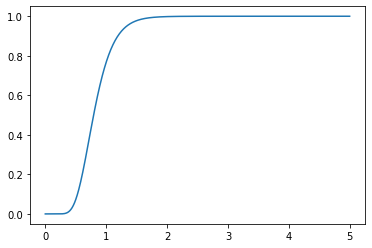

In [18]:
xs = np.linspace(0, 5, 1000)
ys = cdf_urm1_d4(xs)
plt.plot(xs, ys)

## Quakeledger
Now we are interested in the events in our region.

In [19]:
ID_QUAKELEDGER = 'org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess'

In [20]:
execution_quakeledger = server.execute(
    identifier=ID_QUAKELEDGER, 
    inputs=[
        ('input-boundingbox', wps.BoundingBoxDataInput([-70, 288 - 360, -10, 292 - 360], 'EPSG:4326')),
        ('mmin', '6.6'),
        ('mmax', '8'),
        ('zmin', '5'),
        ('zmax', '140'),
        ('p', '140'),
        ('etype', 'expert'),
        ('tlon', '-71.5730623712764'),
        ('tlat', '-33.1299174879672'),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_quakeledger)
print('Successful: {}'.format(execution_quakeledger.isSucceded()))

Successful: True


In [21]:
quakeledger_output_reference = execution_quakeledger.processOutputs[0].reference
quakeledger_output = le.fromstring(requests.get(quakeledger_output_reference).content)

In [22]:
quakeledger_output

<Element {http://quakeml.org/xmlns/bed/1.2}eventParameters at 0x7f805b4d30c8>

In [23]:
quakeledger_output_df = gfzwpsformatconversions.QuakeML.from_xml(quakeledger_output).to_geodataframe()

In [24]:
quakeledger_output_df.head()

eventID agency Identifier  year month day hour minute  \
0  quakeml:quakeledger/90000110    GFZ        NaN  2018     1   1    0      0   
1  quakeml:quakeledger/90000111    GFZ        NaN  2018     1   1    0      0   
2  quakeml:quakeledger/90000112    GFZ        NaN  2018     1   1    0      0   
3  quakeml:quakeledger/90000113    GFZ        NaN  2018     1   1    0      0   
4  quakeml:quakeledger/80674980    GFZ        NaN  2019     1   1    0      0   

  second timeUncertainty  ... magnitudeUncertainty rake rakeUncertainty dip  \
0      0             NaN  ...                  NaN   90             NaN  18   
1      0             NaN  ...                  NaN   90             NaN  18   
2      0             NaN  ...                  NaN   90             NaN  18   
3      0             NaN  ...                  NaN   90             NaN  18   
4      0             NaN  ...                  NaN   90             NaN  20   

  dipUncertainty strike strikeUncertainty    type probability  \
0            NaN      9               NaN  expert         NaN   
1            NaN      9               NaN  expert         NaN   
2            NaN      9               NaN  expert         NaN   
3            NaN      9               NaN  expert         NaN   
4            NaN      9               NaN  expert         NaN   

                    geometry  
0  POINT (-71.7235 -30.4383)  
1  POINT (-71.8082 -30.8819)  
2  POINT (-71.8938 -31.3255)  
3  POINT (-71.9802 -31.7691)  
4  POINT (-71.8004 -32.9143)  

[5 rows x 31 columns]

In [25]:
def get_bbox(geom_column):
    return [
        geom_column.x.min() - 1,
        geom_column.x.max() + 1,
        geom_column.y.min() - 1,
        geom_column.y.max() - 1
    ]
quakes_region = get_bbox(quakeledger_output_df.geometry)

In [26]:
quakes_region

[-72.9827, -70.3408, -34.8527, -31.4383]

In [27]:
def plot_quakedger(df):
    geom_column = df.geometry
    bbox = [
        geom_column.x.min() - 1,
        geom_column.x.max() + 1,
        geom_column.y.min() - 1,
        geom_column.y.max() - 1
    ]
    fig = plt.figure(figsize=(6, 12))
    mp = Basemap(projection='cyl', resolution='h', 
                 lat_0=bbox[2], lon_0=bbox[0],
                 llcrnrlon=bbox[0],
                 llcrnrlat=bbox[2],
                 urcrnrlon=bbox[1],
                 urcrnrlat=bbox[3]
    )
    mp.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose=False)
    mp.drawcoastlines()
    mp.drawcountries()
    mp.scatter(df.geometry.x, df.geometry.y,
           marker='o',color='m',s = (0.4*df.magnitude.values.astype(float))**4)
    plt.show()

In [28]:
plot_quakedger(quakeledger_output_df)

NameError: name 'Basemap' is not defined

<Figure size 432x864 with 0 Axes>

## Chose an event
Now we want to have chose one of those events and prepare it as input for our shakyground service.

In [29]:
chosen_event = quakeledger_output_df[0:1]

In [30]:
chosen_event

eventID agency Identifier  year month day hour minute  \
0  quakeml:quakeledger/90000110    GFZ        NaN  2018     1   1    0      0   

  second timeUncertainty  ... magnitudeUncertainty rake rakeUncertainty dip  \
0      0             NaN  ...                  NaN   90             NaN  18   

  dipUncertainty strike strikeUncertainty    type probability  \
0            NaN      9               NaN  expert         NaN   

                    geometry  
0  POINT (-71.7235 -30.4383)  

[1 rows x 31 columns]

In [31]:
chosen_event_as_quakeml = gfzwpsformatconversions.QuakeMLDataframe.from_dataframe(chosen_event).to_xml_string()

In [32]:
chosen_event_as_quakeml

'<ns0:eventParameters xmlns:ns0="http://quakeml.org/xmlns/bed/1.2" publicID="quakeml:quakeledger/0">\n  <ns0:event publicID="quakeml:quakeledger/90000110">\n    <ns0:preferredOriginID>quakeml:quakeledger/90000110</ns0:preferredOriginID>\n    <ns0:preferredMagnitudeID>quakeml:quakeledger/90000110</ns0:preferredMagnitudeID>\n    <ns0:type>earthquake</ns0:type>\n    <ns0:description>\n      <ns0:text>expert</ns0:text>\n    </ns0:description>\n    <ns0:origin publicID="quakeml:quakeledger/90000110">\n      <ns0:time>\n        <ns0:value>2018-01-01T00:00:00.000000Z</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:time>\n      <ns0:latitude>\n        <ns0:value>-30.4383</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:latitude>\n      <ns0:longitude>\n        <ns0:value>-71.7235</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:longitude>\n      <ns0:depth>\n        <ns0:value>28.0</ns0:value>\n        <ns0:uncertainty>Na

# Shakyground
Now lets use the chosen event to get the data of the shakemap.

In [33]:
ID_SHAKYGROUND = 'org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess'


In [34]:
execution_shakyground = server.execute(
    identifier=ID_SHAKYGROUND, 
    inputs=[
        ('quakeMLFile', wps.ComplexDataInput(chosen_event_as_quakeml)),
    ],
    output=[('shakeMapFile', True)]
)

wps.monitorExecution(execution_shakyground)
print('Successful: {}'.format(execution_shakyground.isSucceded()))

Successful: True


In [35]:
shakyground_output_reference = execution_shakyground.processOutputs[0].reference
shakyground_output = le.fromstring(requests.get(shakyground_output_reference).content)

In [36]:
execution_shakyground.processOutputs[0].reference

'http://rz-vm140.gfz-potsdam.de:80/wps/RetrieveResultServlet?id=15dd40cf-0762-4163-9750-2c5808f22270shakeMapFile.01883431-bff2-4ffb-81fd-1db2f2094f99'

Now we want to visualize the shakemap.

In [37]:
shakyground_output_intensity_df = gfzwpsformatconversions.Shakemap.from_xml(shakyground_output).to_intensity_geodataframe()

In [38]:
shakyground_output_intensity_df.head()

LON     LAT  value_PGA  value_STDPGA  value_SA(0.3)  \
0 -73.566667 -28.075   0.040359      0.736259       0.060554   
1 -73.558333 -28.075   0.040465      0.736259       0.060751   
2 -73.550000 -28.075   0.040572      0.736259       0.060947   
3 -73.541667 -28.075   0.040678      0.736259       0.061143   
4 -73.533333 -28.075   0.040784      0.736259       0.061339   

   value_STDSA(0.3)  value_SA(1.0)  value_STDSA(1.0) unit_PGA unit_STDPGA  \
0          0.775375       0.034633          0.819875        g           g   
1          0.775375       0.034691          0.819875        g           g   
2          0.775375       0.034749          0.819875        g           g   
3          0.775375       0.034807          0.819875        g           g   
4          0.775375       0.034865          0.819875        g           g   

  unit_SA(0.3) unit_STDSA(0.3) unit_SA(1.0) unit_STDSA(1.0)  \
0            g               g            g               g   
1            g               g            g               g   
2            g               g            g               g   
3            g               g            g               g   
4            g               g            g               g   

                             geometry  
0      POINT (-73.5666666667 -28.075)  
1      POINT (-73.5583333333 -28.075)  
2              POINT (-73.55 -28.075)  
3      POINT (-73.5416666667 -28.075)  
4  POINT (-73.53333333329999 -28.075)

In [39]:
raster = gfzwpsformatconversions.Shakemap.dataframe2raster(shakyground_output_intensity_df, 'LON', 'LAT', 'value_PGA')

In [40]:
event_dataframe = gfzwpsformatconversions.Shakemap.from_xml(shakyground_output).to_event_geodataframe_or_none()

In [41]:
def plot_shakemap(raster, events, additional_spacing=1):
    cmap = plt.get_cmap('YlOrBr')
    z = raster.raster.data
    y_count, x_count = z.shape
    x_s = np.linspace(raster.xmin, raster.xmax, x_count)
    # the image coordinates for ys go down
    y_s = np.linspace(raster.ymax, raster.ymin, y_count)
    
    # dont plot some values
    # to make the image not that full
    zz = np.ma.masked_array(z, z < 0.1)
    
    bbox = raster.bounds
    fig = plt.figure(figsize=(6, 12))
    mp = Basemap(projection='cyl', resolution='h', 
                 #lat_0=bbox[2], 
                 #lon_0=bbox[0],
                 llcrnrlon=bbox[0] - additional_spacing,
                 llcrnrlat=bbox[1] - additional_spacing,
                 urcrnrlon=bbox[2] + additional_spacing,
                 urcrnrlat=bbox[3] + additional_spacing
    )
    mp.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose=False)
    mp.drawcoastlines()
    mp.drawcountries()
    cs = mp.pcolormesh(x_s, y_s, zz, zorder=98, alpha=0.3, cmap=cmap)
    mp.colorbar(cs, extend='min')
    
    mp.scatter(events.geometry.x, events.geometry.y,
               zorder=99,
               marker='*',color='red',s = 30**2)
    plt.show()

In [42]:
plot_shakemap(raster, event_dataframe)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


NameError: name 'Basemap' is not defined

<Figure size 432x864 with 0 Axes>

# Deus
At the moment the last service to use here.

In [43]:
ID_DEUS = 'org.n52.gfz.riesgos.algorithm.impl.DeusProcess'

In [44]:
len(le.tostring(shakyground_output))

25202551

In [45]:
execution_deus = server.execute(
    identifier=ID_DEUS, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('exposure', wps.ComplexDataInput(assetmaster_output_pure)),
        ('fragility', wps.ComplexDataInput(modelprop_output_pure)),
        ('intensity', wps.ComplexDataInput(le.tostring(shakyground_output)))
    ],
    output=[
        ('updated_exposure', True),
        ('transition', True),
        ('damage', True),
    ]
)

wps.monitorExecution(execution_deus)
print('Successful: {}'.format(execution_deus.isSucceded()))

Successful: True


# Failing is ok
If this fails, we just see that the assetmaster and modelprop outputs are not conform to each other.
As this is the current return value of the services it is ok, that the deus service fails.
We will now chose some data that we can use without generating an error.

In [45]:
#def read_string_from_file(file):
#    with open(file, 'rt') as input_file:
#        return input_file.read()
#
#execution_deus = server.execute(
#    identifier=ID_DEUS, 
#    inputs=[
#        ('schema', 'SARA_v1.0'),
#        ('exposure', wps.ComplexDataInput(read_string_from_file('testinputs/exposure_sara.json'))),
#        ('fragility', wps.ComplexDataInput(read_string_from_file('testinputs/fragility_sara.json'))),
#        
#        #('intensity', wps.ComplexDataInput(le.tostring(shakyground_output, encoding='unicode')))
#        # this here doesn't work either at the moment
#        # we have have a look for what happens here
#        
#        ('intensity', wps.ComplexDataInput(read_string_from_file('testinputs/shakemap.xml')))
#        
#    ],
#    output=[
#        ('updated_exposure', True),
#        ('transition', True),
#        ('damage', True),
#    ]
#)

#wps.monitorExecution(execution_deus)
#print('Successful: {}'.format(execution_deus.isSucceded()))

Successful: True


In [46]:
updated_exposure_model_reference = execution_deus.processOutputs[0].reference
updated_exposure_model_df = gpd.read_file(updated_exposure_model_reference, )

In [47]:
updated_exposure_model_transitions =  requests.get(execution_deus.processOutputs[1].reference).json()

In [48]:
updated_exposure_model_transitions

{'features': [{'geometry': {'coordinates': [[[-71.4765109995829,
       -33.01033200032151],
      [-71.47608199958455, -33.014376999798685],
      [-71.47731699987958, -33.01484499979688],
      [-71.4809049998658, -33.01368600030861],
      [-71.48144799972539, -33.01277100038129],
      [-71.4810930004416, -33.01122199999526],
      [-71.47908499957305, -33.00957100030138],
      [-71.4765109995829, -33.01033200032151]]],
    'type': 'Polygon'},
   'properties': {'gid': '0 1',
    'name': 'VINA DEL MAR',
    'schema': 'SARA_v1.0',
    'transitions': {'from_damage_state': [],
     'n_buildings': [],
     'taxonomy': [],
     'to_damage_state': []}},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[-71.48944699987908, -32.99857899972102],
      [-71.48819599974553, -33.00068100042779],
      [-71.48920000017984, -33.00204400033033],
      [-71.49111899964208, -33.00168099977827],
      [-71.49144500028649, -33.000050000107365],
      [-71.4895459999479, -32.9985619998364],
   

In [49]:
updated_exposure_model_df

gid          name                                               expo  \
0        0 1  VINA DEL MAR  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
1       0 10  VINA DEL MAR  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
2     0 1005  VINA DEL MAR  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
3     0 1008  VINA DEL MAR  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
4      0 101  VINA DEL MAR  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
...      ...           ...                                                ...   
2587   1 991    VALPARAISO  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
2588   1 992    VALPARAISO  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
2589   1 993    VALPARAISO  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
2590   1 995    VALPARAISO  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   
2591   1 999    VALPARAISO  {'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...   

                                               geometry  
0     POLYGON ((-71.4765109995829 -33.01033200032151...  
1     POLYGON ((-71.48944699987908 -32.9985789997210...  
2     POLYGON ((-71.55798300021524 -33.0261810000530...  
3     POLYGON ((-71.55057300024373 -33.0167959998354...  
4     POLYGON ((-71.53613700002251 -33.0540340002688...  
...                                                 ...  
2587  POLYGON ((-71.46055899959811 -33.1811739997802...  
2588  POLYGON ((-71.57578299998545 -33.1330710001265...  
2589  POLYGON ((-71.59109300004189 -33.0657669999470...  
2590  POLYGON ((-71.67574599987796 -33.1487259999049...  
2591  POLYGON ((-71.64934299997941 -33.0467499998126...  

[2592 rows x 4 columns]

In [58]:
updated_exposure_model_df['expo'].apply(lambda x: set(x['Damage']))

0           {D4, D3, D2, D1}
1       {D3, D2, D1, D4, D0}
2       {D3, D2, D1, D4, D0}
3       {D3, D2, D1, D4, D0}
4       {D3, D2, D1, D4, D0}
                ...         
2587        {D4, D3, D2, D1}
2588    {D3, D2, D1, D4, D0}
2589    {D3, D2, D1, D4, D0}
2590        {D4, D3, D2, D1}
2591    {D3, D2, D1, D4, D0}
Name: expo, Length: 2592, dtype: object

# Next steps
The next steps are more support for the assetmaster, modelprop and deus as they need to work togehter.
Also we may can provide a wps client library on top of the code here to access the services mentioned here and as a skeleton on how to write clients for other services as well.

In [60]:
execution_modelprop_supp = server.execute(
    identifier=ID_MODELPROP, 
    inputs=[
        ('schema', 'SUPPASRI2013_v2.0'),
        ('assetcategory', 'buildings'),
        ('losscategory', 'structural'),
        ('taxonomies', ''),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_modelprop_supp)
print('Successful: {}'.format(execution_modelprop_supp.isSucceded()))
modelprop_output_reference_supp = execution_modelprop_supp.processOutputs[0].reference
modelprop_output_pure_supp = requests.get(modelprop_output_reference_supp).text
modelprop_output_supp = requests.get(modelprop_output_reference_supp).json()

Successful: True


In [61]:
modelprop_output_supp

{'data': [{'D1_mean': -2.4562,
   'D1_stddev': 1.4874,
   'D2_mean': -1.1373,
   'D2_stddev': 1.115,
   'D3_mean': -0.0756,
   'D3_stddev': 0.8277,
   'D4_mean': 0.5316,
   'D4_stddev': 0.6235,
   'D5_mean': 0.8336,
   'D5_stddev': 0.6077,
   'D6_mean': 1.2244,
   'D6_stddev': 0.5723,
   'id': 'unique_id',
   'im_max': 20.0,
   'im_min': 0.0,
   'imt': 'ID',
   'imu': 'm',
   'taxonomy': 'MIX'},
  {'D1_mean': -1.6956,
   'D1_stddev': 1.1013,
   'D2_mean': -0.8982,
   'D2_stddev': 0.8835,
   'D3_mean': 0.0662,
   'D3_stddev': 0.7171,
   'D4_mean': 0.7061,
   'D4_stddev': 0.668,
   'D5_mean': 1.4575,
   'D5_stddev': 0.8938,
   'D6_mean': 2.279,
   'D6_stddev': 0.7362,
   'id': 'unique_id',
   'im_max': 20.0,
   'im_min': 0.0,
   'imt': 'ID',
   'imu': 'm',
   'taxonomy': 'S1'},
  {'D1_mean': -1.6956,
   'D1_stddev': 1.1013,
   'D2_mean': -0.8982,
   'D2_stddev': 0.8835,
   'D3_mean': 0.0662,
   'D3_stddev': 0.7171,
   'D4_mean': 0.7061,
   'D4_stddev': 0.668,
   'D5_mean': 1.4575,
   'D5

In [1]:
def read_string_from_file(file):
    with open(file, 'rt') as input_file:
        return input_file.read()



In [2]:
ts_intensity = read_string_from_file('testinputs/shakemap_tsunami.xml')

In [3]:
ts_intensity

'<shakemap_grid xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://earthquake.usgs.gov/eqcenter/shakemap" code_version="None" event_id="80674883" map_status="None" process_timestamp="2019-11-05T12:06:19.557606" shakemap_event_type="None" shakemap_id="80674883" shakemap_originator="_AWI_" shakemap_version="None">\n  <event depth="12695.0" event_description="Tsunami" event_id="80674883" event_network="None" event_timestamp="2019-11-05T12:06:19.557725" lat="-31.9306" lon="-72.3538" magnitude="8.0"/>\n  <grid_specification lat_max="-16.99536" lat_min="-47.00288" lon_max="-69.96918000000001" lon_min="-83.00279" nlat="None" nominal_lat_spacing="None" regular_grid="false"/>\n  <event_specific_uncertainty name="None" numsta="None" value="None"/>\n  <event_specific_uncertainty name="None" numsta="None" value="None"/>\n  <event_specific_uncertainty name="None" numsta="None" value="None"/>\n  <grid_field index="1" name="#ID_poly" units="#"/>\n  <grid_field index="2" name="id1_pol

In [70]:
# we currently don't update the updated exposure, just take the initial one
execution_deus_ts = server.execute(
    identifier=ID_DEUS, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('exposure', wps.ComplexDataInput(assetmaster_output_pure)),
        ('fragility', wps.ComplexDataInput(modelprop_output_pure_supp)),
        ('intensity', wps.ComplexDataInput(ts_intensity))
    ],
    output=[
        ('updated_exposure', True),
        ('transition', True),
        ('damage', True),
    ]
)

wps.monitorExecution(execution_deus_ts)
print('Successful: {}'.format(execution_deus_ts.isSucceded()))

Successful: True


In [72]:
ts_updated_exposure_model_reference = execution_deus_ts.processOutputs[0].reference
ts_updated_exposure_model_df = gpd.read_file(ts_updated_exposure_model_reference, )

In [73]:
ts_updated_exposure_model_df

gid          name                                               expo  \
0        0 1  VINA DEL MAR  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
1       0 10  VINA DEL MAR  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
2     0 1005  VINA DEL MAR  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
3     0 1008  VINA DEL MAR  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
4      0 101  VINA DEL MAR  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
...      ...           ...                                                ...   
2587   1 991    VALPARAISO  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
2588   1 992    VALPARAISO  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
2589   1 993    VALPARAISO  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
2590   1 995    VALPARAISO  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   
2591   1 999    VALPARAISO  {'Taxonomy': ['RC1', 'RC1', 'RC1', 'RC1', 'RC1...   

                                               geometry  
0     POLYGON ((-71.4765109995829 -33.01033200032151...  
1     POLYGON ((-71.48944699987908 -32.9985789997210...  
2     POLYGON ((-71.55798300021524 -33.0261810000530...  
3     POLYGON ((-71.55057300024373 -33.0167959998354...  
4     POLYGON ((-71.53613700002251 -33.0540340002688...  
...                                                 ...  
2587  POLYGON ((-71.46055899959811 -33.1811739997802...  
2588  POLYGON ((-71.57578299998545 -33.1330710001265...  
2589  POLYGON ((-71.59109300004189 -33.0657669999470...  
2590  POLYGON ((-71.67574599987796 -33.1487259999049...  
2591  POLYGON ((-71.64934299997941 -33.0467499998126...  

[2592 rows x 4 columns]

In [78]:
ts_updated_exposure_model_df['expo'].apply(lambda x: set(x['Damage']))

0           {D3, D2, D6, D1, D5, D4}
1       {D3, D2, D6, D1, D5, D4, D0}
2       {D3, D2, D6, D1, D5, D4, D0}
3       {D3, D2, D6, D1, D5, D4, D0}
4       {D3, D2, D6, D1, D5, D4, D0}
                    ...             
2587        {D3, D2, D6, D1, D5, D4}
2588    {D3, D2, D6, D1, D5, D4, D0}
2589    {D3, D2, D6, D1, D5, D4, D0}
2590        {D3, D2, D6, D1, D5, D4}
2591    {D3, D2, D6, D1, D5, D4, D0}
Name: expo, Length: 2592, dtype: object

In [80]:
ts_updated_exposure_model_df['expo'].iloc[7]

{'Buildings': [0.157348,
  0.01513,
  0.032456,
  1.060205,
  0.204331,
  0.353976,
  0.026554,
  2.059235,
  0.030712,
  0.953455,
  2.353724,
  0.976566,
  0.068496,
  0.057812,
  0.664216,
  0.003568,
  0.27218,
  1.251285,
  1.034968,
  0.00093,
  0.092852,
  0.664216,
  0.003568,
  0.27218,
  1.251285,
  1.034968,
  0.00093,
  0.092852,
  0.013336,
  7.2e-05,
  0.012448,
  0.107887,
  0.205583,
  0.000215,
  0.010459,
  0.169359,
  0.002422,
  0.084454,
  0.27729,
  0.384491,
  0.068102,
  0.013883,
  0.058997,
  0.005054,
  0.012838,
  0.573911,
  0.190493,
  0.335545,
  0.023162,
  0.672593,
  0.003944,
  0.269148,
  1.13137,
  0.643973,
  0.000544,
  0.048428,
  0.037096,
  0.000686,
  0.022788,
  0.1149,
  0.204307,
  0.000211,
  0.010011,
  0.001048,
  1.4e-05,
  0.006439,
  0.085065,
  0.197532,
  0.000208,
  0.009694],
 'Damage': ['D6',
  'D5',
  'D4',
  'D3',
  'D2',
  'D1',
  'D0',
  'D6',
  'D5',
  'D4',
  'D3',
  'D2',
  'D1',
  'D0',
  'D6',
  'D5',
  'D4',
  'D3',
  '